# Проект по непрерывной оптимизации
## Программный код


In [0]:
import numpy as np
import scipy.linalg as li
import matplotlib.pyplot as plt

from dataclasses import dataclass

# в данной работе используется евклидова норма

def norm(v):
	return np.sqrt(np.sum(np.square(v)))

### 1. Алгоритм Голуба-Кахана бидиагонализации матрицы

Вход: матрица $A$ размера $m$ на $n$.

Выход: матрицы $U$, $B$, $V$, где $U$ и $V$ — ортогональные, $B$ — бидиагональная.

In [0]:
def bidiagonalize(A):
	m, n = A.shape
	V = np.zeros((n, n))
	U = np.zeros((m, m))
	B = np.zeros((m, n))
 
  # construct unit vector
	v = np.zeros(n)
	v[0] = 1.0
	V[:, 0] = v

  # u will be defined later
	u = np.zeros(m)

	alpha, beta = 0, 0

	for k in range(m):
		u = np.dot(A, v) - beta * u
		alpha = norm(u)
		B[k][k] = alpha
		if alpha != 0:
			u = u / alpha
		U[:, k] = u
		v = np.dot(A.T, u) - alpha * v
		beta = norm(v)
		if beta != 0:
			v = v / beta
		if k + 1 < n:
			B[k][k + 1] = beta
			V[:, k + 1] = v

	return U, B, V

Проверим на матрице 3х3, что алгоритм бидиагонализации Голуба-Кахана работает, т.е. что полученная матрица B достаточно близка к $U^T \cdot A \cdot V$, а $U$ и $V$ имеют единичные определители по модулю.

In [66]:
A = np.array([[1, 2, 1], [4, 5, 6], [7, 8, 9]])
U, B, V = bidiagonalize(A)
print(np.linalg.det(U), np.linalg.det(V)) # ортогональность
print(A, B, np.dot(np.dot(U.T, A), V), sep="\n")

-1.0 -0.9999999999999998
[[1 2 1]
 [4 5 6]
 [7 8 9]]
[[ 8.1240384  14.47463822  0.        ]
 [ 0.          0.85634679  0.08782624]
 [ 0.          0.          0.86244142]]
[[ 8.12403840e+00  1.44746382e+01 -1.00284430e-11]
 [-2.57571742e-14  8.56346791e-01  8.78262407e-02]
 [-9.44594541e-11 -1.68748475e-10  8.62441424e-01]]


Алгоритм действительно выдал ортогональные матрицы и работает на данном примере.

Теперь запустим алгоритм на 1000 случайных матрицах $A \in Mat_{10 \times 10}(\mathbb{R})$, элементы которой равномерно распределены в $(0, 1]$, и проверим, насколько произведение $U^T A V$ отличается от полученной бидиагональной матрицы $B$.

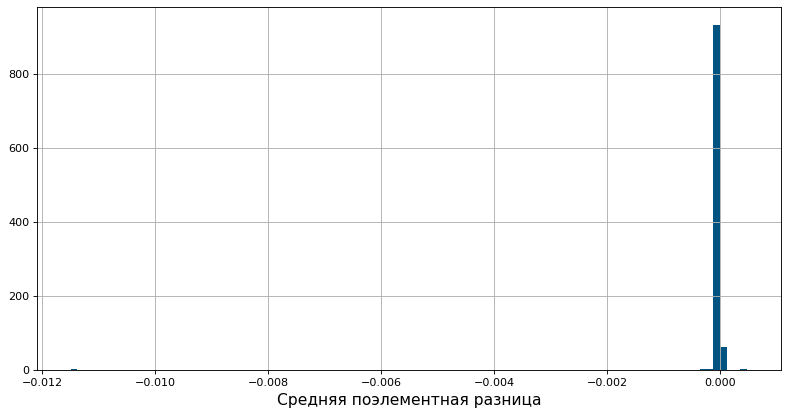

In [67]:
res = []
for i in range(1000):
    A = np.random.rand(7, 10)
    U, B, V = bidiagonalize(A)
    B_test = np.dot(np.dot(U.T, A), V)
    res.append((B_test - B).mean())

fig = plt.figure(dpi=80, figsize=(12, 6))
plt.xlabel("Средняя поэлементная разница", fontsize=14)
plt.grid(True)
plt.hist(res, bins=100, color="xkcd:deep sea blue")
plt.show()
#fig.savefig("test_golub_kahan_7x10_mean.pdf")

Полученная средняя поэлементная разница практически во всех случаях нулевая, с уменьшением размерности "хвост" распределения этой величины уменьшается.

### 2. Оракулы для получения значений функций в точке и значений градиента

In [0]:
#f(x) = x^2 - x

@dataclass
class Oracle:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    '''
    computes the value of function at point x
    '''
    x = x[:, 0]
    return np.array([[x[0]**2 - x[0]]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:, 0]
    return np.array([[2 * x[0] - 1]])

  def shape(self):
    return (1, 1)

In [0]:
# f(x, y) = (x^2 - 2x + 1) + (y^2 + 5y - 6) + 10

@dataclass
class Oracle2:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    
    '''
    computes the value of function at point x
    '''
    x = x[:,0]
    return np.array([[x[0]**2 - 2 * x[0] + 1 + x[1]**2 + 5 * x[1] - 6]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:,0]
    return np.array([[2 * x[0] - 2, 2 * x[1] + 5]])

  def shape(self):
    return (1, 2)

In [0]:
# f(x, y) = x^4 - x + y^4 - 2y^2 + 1

@dataclass
class Oracle3:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    
    '''
    computes the value of function at point x
    '''
    x = x[:,0]
    return np.array([[x[0]**4 - x[0] + x[1]**4 - 2 * x[1]**2 + 1]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:,0]
    return np.array([[4 * x[0]**3 - 1, 4 * x[1]**3 - 4 * x[1]]])

  def shape(self):
    return (1, 2)

In [0]:
# f(x, y) = ( (x - 2y)^2, y^2 ) 

@dataclass
class Oracle4:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    
    '''
    computes the value of function at point x
    '''
    x = x[:,0]
    return np.array([[(x[0] - 2 * x[1])**2], [x[1]**2]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:,0]
    return np.array([[ 2*(x[0] - 2 * x[1]), -4*(x[0] - 2 * x[1]) ], [ 0, 2 * x[1] ]])

  def shape(self):
    return (2, 2)

### 3. Модификация градиентного метода Гаусса-Ньютона 

Вспомогательные функции, в том числе минимизация $\hat\psi$:

In [0]:
def psi(oracle, x, y, i, L):
  return phi(oracle, x, y) + 2 ** (i - 1) * L * np.sum(np.square(y - x))


def hat_psi(oracle, x, y, i, L):
  f1 = oracle.f_1(x)
  return L / 2 * np.sum(np.square(y - x)) + 1 / (2 * f1) * (f1 * f1 + np.sum(np.square(oracle.F(x) + oracle.dF(x) * (y - x))) )


def get_hat_psi_argmin(oracle, x, i, L):
  n, m = oracle.shape()
  new_L = 2**i * L
  dF = oracle.dF(x)
  U, B, V = bidiagonalize(dF)
  f_1 = oracle.f_1(x)
  dFtdF = dF.T @ dF
  b = new_L * f_1 * x + dFtdF @ x - dF.T @ oracle.F(x)
  tridiagonal_matrix = B.T @ B
  tridiagonal_matrix += new_L * f_1 * np.eye(tridiagonal_matrix.shape[0])
  T = (V.T @ li.inv(tridiagonal_matrix) @ V) @ b
  return T


Непосредственно градиентный спуск:

In [0]:
@dataclass
class GradientDescent():

  def do_gd(self, oracle, start_point, eps, L0, rule, verbose=False):
    n, m = oracle.shape()

    def T(x, L):
      F_cnt = oracle.F(x)
      i = 0
      result = None
      while 1:
        # calculate T = argmin(psi(i, L, f))
        result = get_hat_psi_argmin(oracle, x, i, L)
        # find the smallest i for which the inequality is satisfied
        if oracle.f_1(result) < hat_psi(oracle, x, result, i, L):
          break
        i += 1
      return result, L * 2**(i - 1)

    x = np.array(start_point).reshape((m, 1))
    z = np.zeros((m, 1)) # zero vector

    X = [x]
    y, L = T(X[0], L0)
    Y = [x, y]

    k = 0
    while True:
      k += 1
      if verbose:
        print("\nSTEP", k)

      y = Y[k]
      if verbose:
        print("current point is", y[:,0], " ||F|| =", oracle.f_1(y))
      x, L = T(y, L) # (a)
      if norm(y - x) <= eps:
        break

      if verbose:  
        print("||y-x|| =", norm(y - x))


      X.append(x)

      psi = lambda tau: oracle.f_1(X[k - 1] + tau * (X[k] - X[k - 1])) # (b)
      def d_psi(tau): # psi derivative
        delta_x = X[k] - X[k - 1]
        h = X[k - 1] + tau * delta_x
        return (h.T @ delta_x) #/ norm(h)

      # (c)
      tau = 1
      if rule == 'armijo':
        alpha = 1/3
        beta = 2/3
        psi0 = psi(0)
        d_psi0 = d_psi(0)

        cond61 = lambda tau: psi0 + beta * d_psi0 * tau <= psi(tau) <= psi0 + alpha * d_psi0 * tau
        cond621 = lambda tau: psi0 + beta * d_psi0 * tau > psi(tau)
        cond622 = lambda tau: psi0 + alpha * d_psi0 * tau < psi(tau)

        if verbose:  
          print("start localization")

        # localization stage
        tau1, tau2 = 1, 1
        if not cond61(tau):
          assert(cond621(tau) or cond622(tau))
          if cond621(tau):
            tau1 = 1
            tau2 = 2 * tau1
          else:
            tau2 = 1
            tau1 = tau2 / 2
        
          while not (cond621(tau1) and cond622(tau2)):
            if verbose:
              print(tau1, cond621(tau1), tau2, cond622(tau2))            
            if cond621(tau1) and (not cond622(tau2)):
              tmp = tau1
              tau1 = tau2
              tau2 = 2 * tmp
            elif cond622(tau2) and (not cond621(tau1)):
              tmp = tau2
              tau2 = tau1
              tau1 = tmp / 2
            elif (not cond621(tau1)) and (not cond622(tau2)):
              raise RuntimeError
        
          if verbose:  
            print("start specification", tau1, tau2, L0)

          # specification stage
          assert(cond621(tau1) and cond622(tau2))

          tau = (tau1 + tau2) / 2
          while not cond61(tau):
            if cond621(tau) and (not cond622(tau)):
              tau1 = tau
            elif (not cond621(tau)) and cond622(tau):
              tau2 = tau
            else:
              raise RuntimeError
            tau = (tau1 + tau2) / 2
        
          if verbose:
            print("armijo rule done")

      elif rule == 'extrapolation':
        taus = [0, 1]

        i = 1
        while d_psi(taus[i]) < 0 and psi(taus[i]) <= psi(taus[i - 1]):
          taus.append(2 * taus[-1])
          i += 1
        
        tau = taus[-1]
      
      else:
        raise RuntimeError

      # (d)
      Y.append(X[k - 1] + tau * (X[k] - X[k - 1]))

    return Y # full history

### 4. Проверка работы полученного метода

Сначала запустим на простой функции $f: \mathbb{R}^2 \to \mathbb{R^2}$ (см. оракул 4) и построим график зависимости нормы функции от номера итерации.

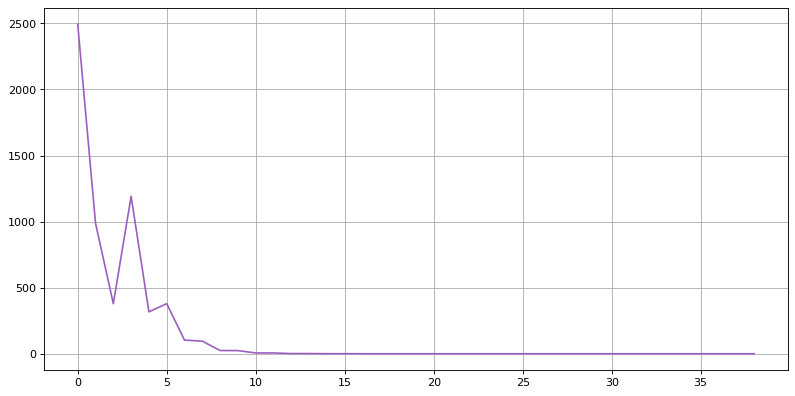

In [74]:
GD = GradientDescent()
o4 = Oracle4()
rule = "extrapolation"
points_history = GD.do_gd(o4, np.array([[21], [34]]), 0.0001, 5, rule, verbose=False)
function_value_history = [o4.f_1(x) for x in points_history]

fig = plt.figure(dpi=80, figsize=(12, 6))
plt.plot(function_value_history, color="xkcd:amethyst")
plt.grid(True)
plt.show()

Визуально, сходимость есть.

Теперь рассмотрим влияние параметра $L_0$ на сходимость метода. Для этого запустим алгоритм на простой функции и построим график зависимости значения в найденном оптимуме $f(x^*)$ от $L_0$.

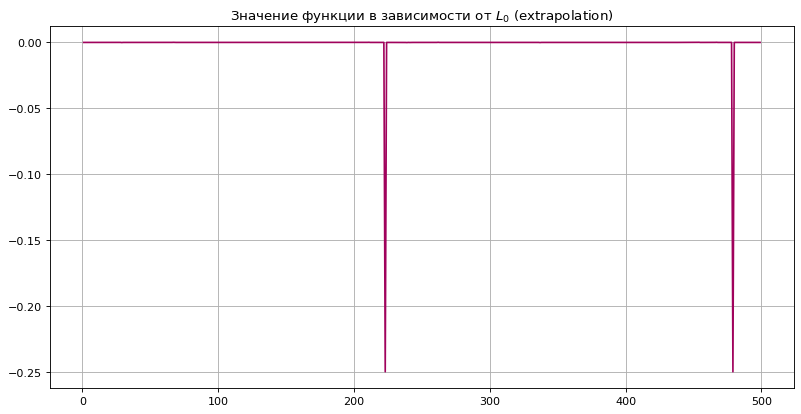

In [75]:
def main():
  oracle = Oracle()
  GD = GradientDescent()

  rule = "extrapolation"
  results = []
  L0s = np.arange(1, 500)
  for L0 in L0s:
    try:
      points_history = np.array(GD.do_gd(oracle, np.array([[5]]), 0.0001, L0, rule, verbose=False))
      function_value_history = [oracle.F(x)[0,0] for x in points_history]
      ans = function_value_history[-1]
      results.append(ans)
    except:
      results.append(1) # метод не сошелся
  fig = plt.figure(dpi=80, figsize=(12, 6))
  plt.title("Значение функции в зависимости от $L_0$ ({})".format(rule))
  plt.plot(L0s, results, color="xkcd:deep magenta")
  plt.grid(True)
  plt.show()
#  fig.savefig("momentum_{}_L0_1.pdf".format(rule))

main()

В данном случае метод с применением экстраполяции для выбора длины шага сходится при любом заданном значении $L_0$.

Теперь сравним поведение метода для экстраполяции и правила Армихо с заранее подобранными стартовыми параметрами.

extrapolation iterations: 27
armijo iterations: 22


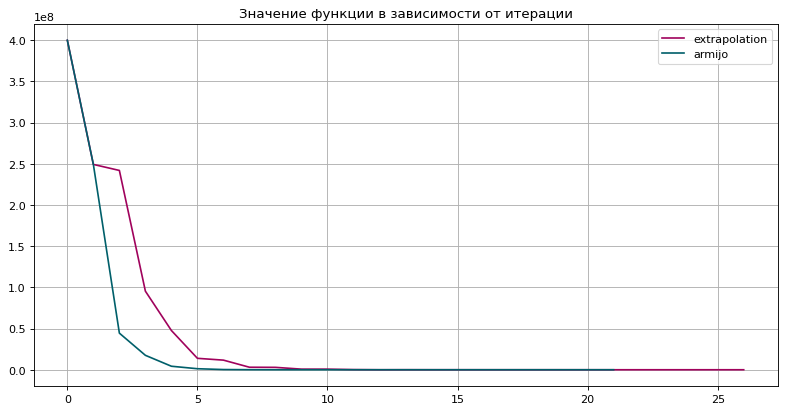

In [76]:
def main():
  oracle = Oracle()
  GD = GradientDescent()

  points_history_extra = np.array(GD.do_gd(oracle, np.array([[20000]]), 0.0001, 5.5, "extrapolation"))
  function_value_history_extra = [oracle.F(x)[0,0] for x in points_history_extra]
  points_history_armijo = np.array(GD.do_gd(oracle, np.array([[20000]]), 0.0001, 5.5, "armijo"))
  function_value_history_armijo = [oracle.F(x)[0,0] for x in points_history_armijo]
  print("extrapolation iterations:", len(function_value_history_extra))
  print("armijo iterations:", len(function_value_history_armijo))

  fig = plt.figure(dpi=80, figsize=(12, 6))
  plt.title("Значение функции в зависимости от итерации")
  plt.plot(function_value_history_extra, color="xkcd:deep magenta", label="extrapolation")
  plt.plot(function_value_history_armijo, color="xkcd:petrol", label="armijo")
  plt.legend()
  plt.grid(True)
  plt.show()
#  fig.savefig("momentum_1_test.pdf")

main()

Можно видеть, что при хорошо подобранных начальных параметрах метод с приминением правила Армихо сходится быстрее даже при очень далекой начальной точке $x_0$.